Columns used for clustering: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0   9.446992  9.175438  8.930891  5.370638          7.891705    7.199678
1   8.861917  9.191259  9.166284  7.474772          8.099858    7.482682
2   8.756840  9.083529  8.947026  7.785721          8.165364    8.967632
3   9.492960  7.087574  8.348064  8.764834          6.230481    7.489412
4  10.026413  8.596189  8.881697  8.272826          7.483244    8.553718


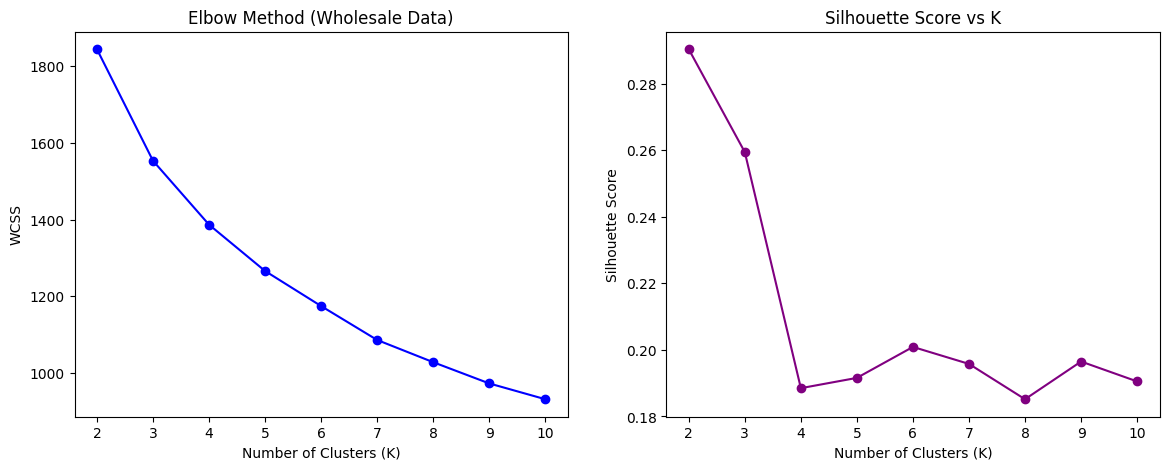

Optimal number of clusters based on Silhouette Score: 2


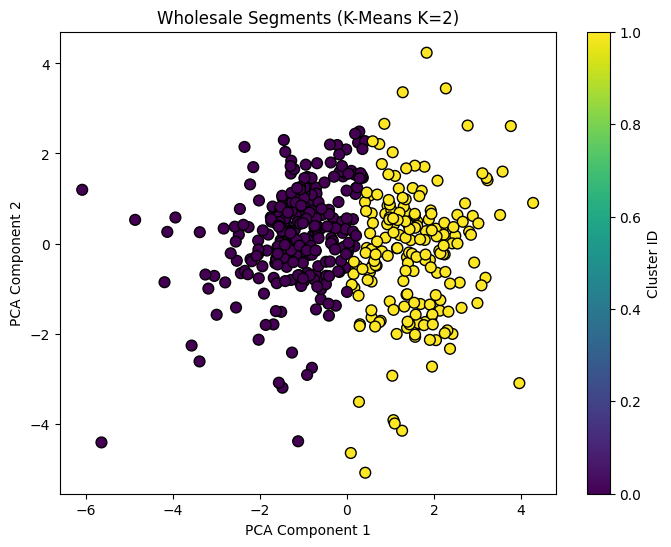

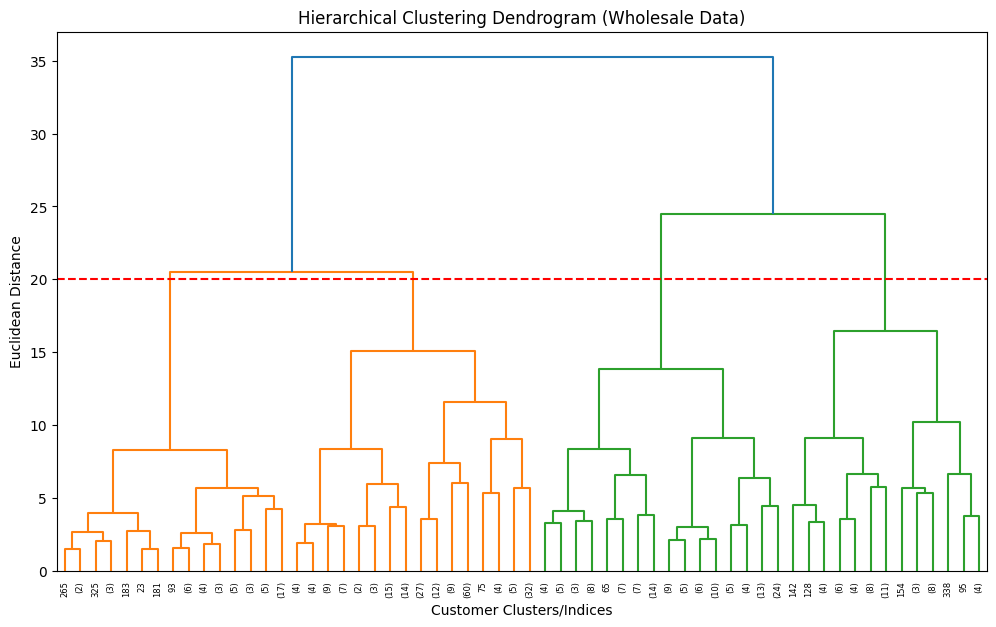

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Load Dataset directly for Google Colab
# Using the Wholesale Customers dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# 2. Preprocessing
# We focus on the 6 product categories for clustering
# Dropping 'Channel' and 'Region' as they are categorical identifiers
cols_to_drop = ['Channel', 'Region']
df_numeric = df.drop(columns=cols_to_drop)

# NOTE: Wholesale data is often heavily skewed.
# Applying Log Transformation helps distance-based algorithms like K-Means/Hierarchical.
df_log = np.log1p(df_numeric)

# Handle any potential missing values (though this dataset is usually clean)
df_log = df_log.fillna(df_log.mean())

print("Columns used for clustering:", df_log.columns.tolist())
print(df_log.head())

# 3. Feature Scaling
# Standardization is critical for distance-based clustering [cite: 504, 505]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log)

# 4. Finding Optimal K (Elbow Method & Silhouette Score)
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plotting Elbow and Silhouette side-by-side [cite: 598]
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o', color='blue')
plt.title('Elbow Method (Wholesale Data)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='purple')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# Optimal K selection based on the highest Silhouette Score [cite: 613]
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

# 5. Final K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 6. PCA for 2D Visualization [cite: 619, 620]
# Reducing 6 features to 2 components for visual inspection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
            cmap='viridis', s=60, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Wholesale Segments (K-Means K={optimal_k})")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

# 7. Hierarchical Clustering (Dendrogram) [cite: 630, 751]
# Using Ward Linkage to minimize within-cluster variance [cite: 819]
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Wholesale Data)")
plt.xlabel("Customer Clusters/Indices")
plt.ylabel("Euclidean Distance")

# Visual threshold for optimal cut
# Adjusting threshold y-value based on the log-scaled distribution
plt.axhline(y=20, color='r', linestyle='--')
plt.show()